# Eye-tracker pupil detection model   
<hr></hr>
<b>Author:</b> Owen Burt  

<b>Date created:</b> 2/21/2025

<b>Last modified</b> 4/26/2025  

<hr></hr>

<b>Description:</b>  

In this notebook I prepare data and construct a model that predicts the location of a pupil. 

<b>References:</b>  
- Referenced <b>mathworks.com</b> to learn about r-cnn, fast r-cnn, and faster r-cnn.
- Referenced and used code from the AI text book 'Applied Machine Learning and AI for Engineers' used in the AI/ML course by <b>Jeff Prosise</b>.
- Referenced and used code from <b>Tensorflow</b> to help understand tensorflows framework, use their pre-trained models, and output images with matlibplot.
- Referneced paper on Faster Convolutional Neural Networks from Cornell Univeristy called 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks' by <b>Shaoqing Ren, et al</b>. I used this article to help me understand the Faster R-CNN.  
- Referenced 'Everything you need to know about VGG16' by <b>Rohini G</b> to help me build a model that closly replicates the VGG16 model commonly used for object classification. 

<b>Sources:</b>  
- mathworks.com: https://www.mathworks.com/help/vision/ug/getting-started-with-r-cnn-fast-r-cnn-and-faster-r-cnn.html
- Tensorflow: https://www.tensorflow.org/tutorials/images/cnn
- Cornell Univeristy: https://arxiv.org/abs/1506.01497  
- VGG16 schema (Rohini G) https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918  


<hr></hr>
  


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os as os
import cv2


<hr></hr>

## Data preprocessing

I'm starting with a folder containing all the images and their corresponding annotations as well as a CSV that contains the file name of the image and the boundries of the pupil. In order to train a model on this data I will need each image (features) to be a 3D array conatinaing pixel data and the boundries (target) to be an array that corresponds to the correct image in the 3D array of images. I will also split the data so that I can use some for training and some for testing and validation. 


<hr></hr>

In [223]:
cwd = os.getcwd()
df = pd.read_csv(cwd + "/eye_data.csv")


In [224]:
df.head()

,file_name,obj_class,x1,y1,x2,y2
0,WIN_20250205_16_00_55_Pro.jpg,pupil,257,163,276,195
1,WIN_20250205_16_00_56_Pro.jpg,pupil,279,128,308,156
2,WIN_20250205_16_00_57_Pro.jpg,pupil,313,138,346,170
3,WIN_20250205_16_00_58_Pro.jpg,pupil,278,141,305,172
4,WIN_20250205_16_00_59_Pro.jpg,pupil,263,150,286,181


Creating a function that allows me to view the image and bounding boxes to ensure no major mistakes are made during data processing.

In [225]:
def view_image(image, x1, y1, x2, y2):
    ''' 
    view_image displays the bounding box on the image.

    :param image: a numpy array representing the image.
    :param x1: x min coordinates.
    :param y1: y min coordinates.
    :param x2: x max coordinates.
    :param y2: y max coordinates.
    '''

    image = image.copy()
    color = (0, 255, 0)
    thickness = 2

    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    cv2.imshow('Bounding Box', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [226]:
x1 = df['x1'][0]
y1 = df['y1'][0]
x2 = df['x2'][0]
y2 = df['y2'][0]
try:
    img_path = cwd + '\\data\\images\\train\\' + df['file_name'][0]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)
except:
    img_path = cwd + '\\data\\images\\val\\' + df['file_name'][0]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)



### Splitting data into training, testing, and validation groups.


My training data will be 75% of original dataset, testing will be 10%, and validation will be 15%. After creating a few models I realized that I didn't need any testing data and could have gotten away with training and validation splits leaving more images for training. 


In [227]:

from sklearn.model_selection import train_test_split

X = df['file_name']
y = df[['x1', 'y1', 'x2', 'y2']]

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio)) 



Resetting indices

In [228]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


In [229]:
x1 = y_train['x1'][1]
y1 = y_train['y1'][1]
x2 = y_train['x2'][1]
y2 = y_train['y2'][1]

try:
    img_path = cwd + '\\data\\images\\train\\' + X_train[1]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)
except:
    img_path = cwd + '\\data\\images\\val\\' + X_train[1]
    img = cv2.imread(img_path)
    view_image(img, x1, y1, x2, y2)


In [230]:
X_val.head()

0    WIN_20250205_16_21_04_Pro.jpg
1    WIN_20250208_18_40_40_Pro.jpg
2    WIN_20250205_16_22_50_Pro.jpg
3    WIN_20250205_16_22_05_Pro.jpg
4    WIN_20250208_18_43_55_Pro.jpg
Name: file_name, dtype: object

In [231]:
y_val.head()

,x1,y1,x2,y2
0,294,129,325,157
1,279,125,308,154
2,270,167,290,195
3,270,155,291,185
4,305,148,325,169


### Converting images and boundry data to arrays and normalizing 

Currently, <b>X_data</b> is a <u>series</u> of file names and <b>y_data</b> is a <u>dataframe</u> containing boundry data. I want the training data to be an <u>array</u> of pixel data and the target data to be an <u>array</u> containing just the boundries with no labels/index. I will create a function that handles both of these tasks. Along with converting data to array format these funcitons will also handle normalizing the data. For the images I do this by dividing the pixel data by 255 since a pixel is comprised of three values ranging from 0 to 255. Dividing by 255 gives me pixel data that ranges from 0 to 1. I treat the boudries similarly and divide x values by the width of my image and y values by the height leaving me with boundry data that ranges form 0 to 1. 


In [232]:
type(X_test[1])

str

#### Creating functions

In [234]:
def images_to_arr(X):
    '''
    images_to_arr gets image path, loads the image, then converts it to a 3D array. 
    
    :param X: the series of image file names to be converted.
    '''
    X_data = []
    for i in range(len(X)):
        try:
            img_path = cwd + '\\data\\images\\train\\' + X[i]
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError()
        except:
            img_path = cwd + '\\data\\images\\val\\' + X[i]
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError()
    
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_512x512 = cv2.resize(gray_img, (512, 512))       
        
        X_data.append(img_512x512)
    return np.array(X_data)


In [235]:
def bounds_to_arr(y_data):
    '''
    bounds_to_arr converts boundry data from a dataframe to a np array containing just the coordinates. 
        It also normalizes the boundry values to be between 0 and 1

    :param y: the dataframe of boundry data to be converted.
    '''
    final = []
    for i in range(len(y_data)):
        df = y_data.loc[i]
        x1new = round((df['x1']/640), 5)
        y1new = round((df['y1']/360), 5)
        x2new = round((df['x2']/640), 5)
        y2new = round((df['y2']/360), 5)
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


#### Executing functions

In [236]:
X_train = images_to_arr(X_train)
y_train = bounds_to_arr(y_train)
X_test = images_to_arr(X_test)
y_test = bounds_to_arr(y_test)
X_val = images_to_arr(X_val)
y_val = bounds_to_arr(y_val)


In [237]:
X_train.shape

(276, 512, 512)

#### Visualizing data after preprocessing is complete

In [238]:
x1 = int(y_train[6][0]*512)
y1 = int(y_train[6][1]*512)
x2 = int(y_train[6][2]*512)
y2 = int(y_train[6][3]*512)
view_image((X_train[6]), x1, y1, x2, y2)


### Cropping the image to get just the eyeball

Making a copy of data to keep a non-cropped verison in needed

In [ ]:
X_train_uncropped = X_train
y_train_uncropped = y_train
X_test_uncropped = X_test
y_test_uncropped = y_test
X_val_uncropped = X_val
y_val_uncropped = y_val

#### Creating functions

In [ ]:
def crop_image(X_data):
    ''' 
    crop_image removes 1/3 from all sides of the image.

    :param X_data: image data as an array.
    '''
    array = []
    for i in range(len(X_data)):
        img = X_data[i]
        img_small = img[171: 341, 171: 341]
        img = np.round(img_small/255, 5)
        array.append(img)
    return np.array(array)


In the function below the additional set_bounds function was added after realizing that my negative images allowed for nevative boundry values after adjusting for the crop. This was causing every model I tried to have terrible accuracy. 

In [ ]:
def set_bounds(bound):
    ''' 
    set_bounds checks whether or not the value needs to be adjusted.

    :param: takes in a float representing the boundry value.
    '''
    if bound > 0:
        bound = bound - 0.33203
    else:
        bound = 0
    return bound

def crop_bounds(y_data):
    ''' 
    crop_bounds adjusts the bounding box coordinates for the new 170x170 image by removing 33% off the x and y boundry values. 

    :param y_data: boundry data as an array. 
    '''
    final = []
    for i in range(len(y_data)):
        arr = y_data[i]
        x1new = set_bounds(arr[0])
        y1new = set_bounds(arr[1])
        x2new = set_bounds(arr[2])
        y2new = set_bounds(arr[3])
        final.append((x1new, y1new, x2new, y2new))
    return np.array(final)


#### Calling functions

In [242]:
X_train = crop_image(X_train)
X_test = crop_image(X_test)
X_val = crop_image(X_val)
y_train = crop_bounds(y_train)
y_test = crop_bounds(y_test)
y_val = crop_bounds(y_val)


In [243]:
X_train.shape

(276, 170, 170)

In [244]:
x1 = int(y_train[1][0]*512)
y1 = int(y_train[1][1]*512)
x2 = int(y_train[1][2]*512)
y2 = int(y_train[1][3]*512)
view_image(X_train[1], x1, y1, x2, y2)


<hr></hr>

## Selecting and Building a Model  

I am beginning by pretty much copying a model from the 'Applied Machine Learning and AI for Engineers' text book to get a benchmark of where the data is at and what my model might need. The originial code can be found in the text book on page 254. I made one edit to the code and changed the loss funciton to mean squared error since my output layer is of size 4.  

<hr></hr>

### Running a Simple Convolutional Neural Network for Experimentation  
 
- Conv2D applies a convolution (2-dimentional for images since images are 2D) to the input image. 
The parameter 64 refers to the number of filters applied in the covolution.
a filter is a stack of kernels. In this case each filter has 3 kernels since there are three channels specified in the input_shape param (image are usually RGB hence 3 channels. one for red one for green one for blue)
The second param (3, 3) specifies the shape of the kerel applied.
I should really learn more about activation functions relu or rectified linear unifying is common but this should be selected based on your data
imput shape refers to the size of the image being passed into the layer. In this case I resized all of my images to be 512 pixels wide and 512 pixels high. Each image is not RGB so maybe I should change the channel.
- Pooling is done to decrease compute time and helps to control overfitting by reducing the feature map output by the previous layer. 
Here were using maxpooling2d with shape 2x2 I am pretty sure this slides a 2x2 matrix across the featuremap reducing that 2x2 portion of the 
image down to a 1x1 block containing the maximum value in the 2x2 matrix.
- Fully connected layers require 1D imputs. A flattening layer is added to convert 2D or 3D tensor (tensor is can be thought of as a n-dimentional matrix in this case 2x2 matrix) into a 1D vector
- The dense layers convert the flattened feature maps to probabilities. the first param is how many output units youwant
In this case my final dense layer has 4 units since I am predicting 4 points for boundries. 
activation matters and I should look more into this.

In [245]:
def show_feat_map(model, data):
    ''' 
    show_feat_map displays the feature map (image) after each filter is applied. 

    :param result: takes in the 4D tensor output from MaxPooling2D layer with format (batch_size, rows, cols, channels). 
    '''

    model.build()
    model.summary()
    result = model.predict(data)
    for i in range(16):
        feature_img = result[0, :, :, i]
        ax = plt.subplot(4, 4, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_img, cmap='grey')
    plt.show


In [246]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

loss = Huber(delta=1.0)

model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
 



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 168, 168, 24)      240       
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 84, 84, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_191 (Conv2D)         (None, 82, 82, 32)        6944      
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 41, 41, 32)       0         
 ng2D)                                                           
                                                                 
Total params: 7,184
Trainable params: 7,184
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 83ms/step

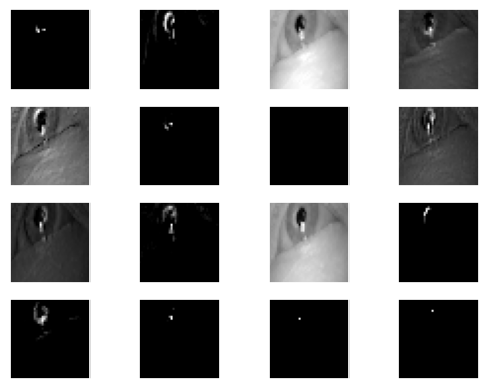

In [247]:
show_feat_map(model, X_test)

In [248]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 168, 168, 24)      240       
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 84, 84, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_191 (Conv2D)         (None, 82, 82, 32)        6944      
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 41, 41, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_192 (Conv2D)         (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 19, 19, 64)     

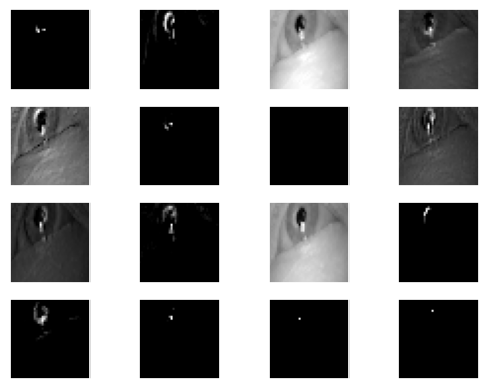

In [249]:
show_feat_map(model, X_test)

In [250]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)

Model: "sequential_23"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_190 (Conv2D)                (None, 168, 168, 24)            240         
                                                                                
 max_pooling2d_109 (MaxPooling2D)   (None, 84, 84, 24)              0           
                                                                                
 conv2d_191 (Conv2D)                (None, 82, 82, 32)              6944        
                                                                                
 max_pooling2d_110 (MaxPooling2D)   (None, 41, 41, 32)              0           
                                                                                
 conv2d_192 (Conv2D)                (None, 39, 39, 64)              18496       
                                                                                
 max_

In [251]:
def view_accuracy_metrics(hist, metrics, validation):
    ''' 
    view_accuracy_metrics displays a graph showing training and validation accuracy.

    :param hist: object containing info about training process.
    '''
    sns.set()
    acc = hist.history[metrics]
    val_acc = hist.history[validation]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

In [252]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=30, epochs=15)

Epoch 1/15
10/10 [==============================] - 1s 27ms/step - loss: 0.0058 - accuracy: 0.2174 - val_loss: 0.0024 - val_accuracy: 0.5636
Epoch 2/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 0.3986 - val_loss: 0.0019 - val_accuracy: 0.4364
Epoch 3/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0020 - accuracy: 0.4601 - val_loss: 0.0015 - val_accuracy: 0.5818
Epoch 4/15
10/10 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 0.4891 - val_loss: 0.0015 - val_accuracy: 0.4727
Epoch 5/15
10/10 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 0.4964 - val_loss: 0.0015 - val_accuracy: 0.5455
Epoch 6/15
10/10 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 0.5580 - val_loss: 0.0014 - val_accuracy: 0.6545
Epoch 7/15
10/10 [==============================] - 0s 14ms/step - loss: 0.0016 - accuracy: 0.5978 - val_loss: 0.0014 - val_accuracy: 0.6727
Epoch 8/15
10

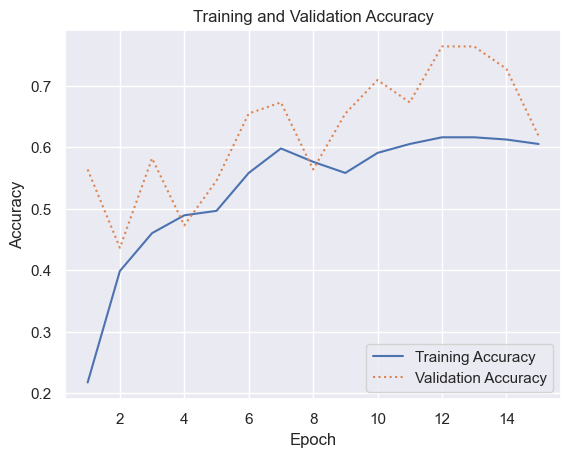

In [253]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [254]:
bounds = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [256]:
view_image(X_test[3], int(bounds[3][0]*512),
            int(bounds[3][1]*512), int(bounds[3][2]*512), int(bounds[3][3]*512))

In [257]:
model.save(cwd + '\\my_models\\my_bad_model1.h5')

<hr></hr>

### Copying VGG16 model

VGG16 is more commonly used as a classification model and has poor results for my application.
I am copying the basic VGG build from a schema found here https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918 

<hr></hr>

In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [259]:
model = Sequential()

In [260]:
#Block 1
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(170, 170, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (None, 170, 170, 64)      640       
                                                                 
 conv2d_195 (Conv2D)         (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 85, 85, 64)       0         
 ng2D)                                                           
                                                                 
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 18ms/step


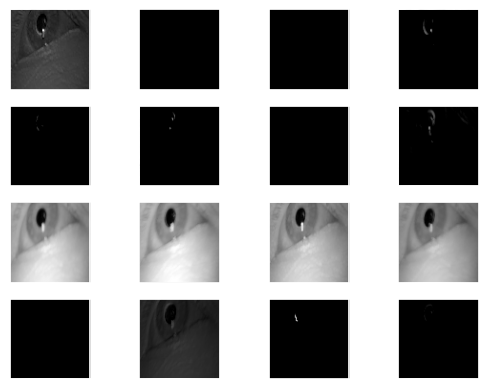

In [261]:
show_feat_map(model, X_test)

In [262]:
#Block 2
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [263]:

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (None, 170, 170, 64)      640       
                                                                 
 conv2d_195 (Conv2D)         (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 85, 85, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 85, 85, 128)       73856     
                                                                 
 conv2d_197 (Conv2D)         (None, 85, 85, 128)       147584    
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                               

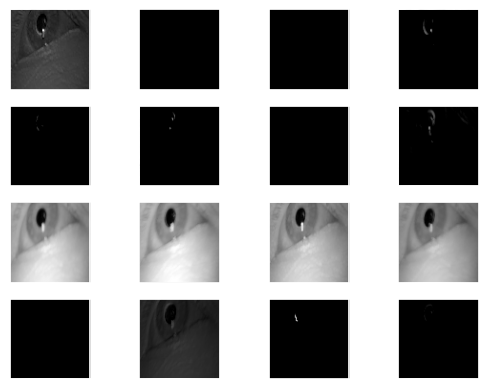

In [264]:
show_feat_map(model, X_test)

In [265]:
#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [266]:
#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (None, 170, 170, 64)      640       
                                                                 
 conv2d_195 (Conv2D)         (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 85, 85, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 85, 85, 128)       73856     
                                                                 
 conv2d_197 (Conv2D)         (None, 85, 85, 128)       147584    
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                               

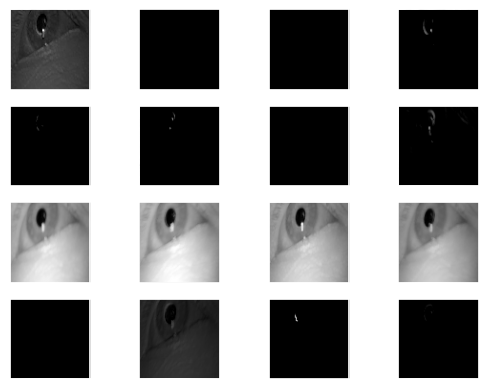

In [267]:
show_feat_map(model, X_test)

In [268]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

In [269]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_194 (Conv2D)         (None, 170, 170, 64)      640       
                                                                 
 conv2d_195 (Conv2D)         (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 85, 85, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 85, 85, 128)       73856     
                                                                 
 conv2d_197 (Conv2D)         (None, 85, 85, 128)       147584    
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                               

In [270]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=12)

Epoch 1/12
28/28 [==============================] - 2s 63ms/step - loss: 82.8257 - mae: 1.7243 - val_loss: 0.0039 - val_mae: 0.0471
Epoch 2/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0035 - mae: 0.0460 - val_loss: 0.0040 - val_mae: 0.0469
Epoch 3/12
28/28 [==============================] - 2s 56ms/step - loss: 0.0034 - mae: 0.0457 - val_loss: 0.0043 - val_mae: 0.0476
Epoch 4/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0034 - mae: 0.0451 - val_loss: 0.0038 - val_mae: 0.0462
Epoch 5/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0035 - val_mae: 0.0470
Epoch 6/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0035 - mae: 0.0461 - val_loss: 0.0039 - val_mae: 0.0460
Epoch 7/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0034 - mae: 0.0450 - val_loss: 0.0036 - val_mae: 0.0467
Epoch 8/12
28/28 [==============================] - 2s 55ms/step - loss: 0.0034 - 

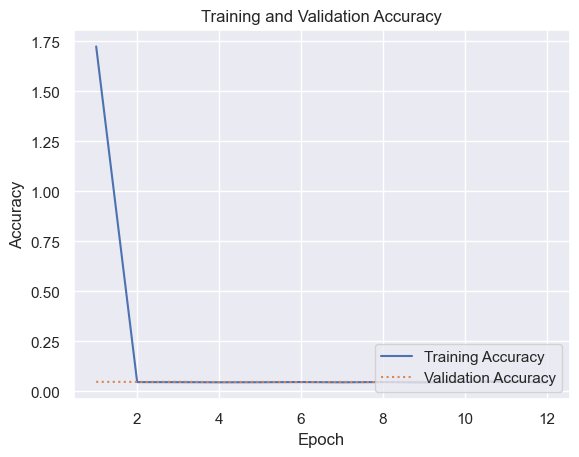

In [271]:
view_accuracy_metrics(hist, 'mae', 'val_mae')

In [272]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 0s 50ms/step


In [273]:
model.save(cwd + '\\my_models\\my_bad_model2.h5')

### Combining VGG16 and initial model

In [ ]:
#First model convlolutions
model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2)) 

#Block 3
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 4
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Block 5
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='linear'))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_206 (Conv2D)         (None, 168, 168, 24)      240       
                                                                 
 max_pooling2d_118 (MaxPooli  (None, 84, 84, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_207 (Conv2D)         (None, 82, 82, 32)        6944      
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 41, 41, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_208 (Conv2D)         (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 19, 19, 64)     

In [275]:
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
                batch_size=10, epochs=32)

Epoch 1/32
28/28 [==============================] - 1s 25ms/step - loss: 0.0932 - mae: 0.1290 - val_loss: 0.0041 - val_mae: 0.0470
Epoch 2/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0463 - val_loss: 0.0036 - val_mae: 0.0453
Epoch 3/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0465 - val_loss: 0.0045 - val_mae: 0.0488
Epoch 4/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0034 - mae: 0.0447 - val_loss: 0.0035 - val_mae: 0.0459
Epoch 5/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0035 - val_mae: 0.0459
Epoch 6/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0445 - val_loss: 0.0038 - val_mae: 0.0453
Epoch 7/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0443 - val_loss: 0.0036 - val_mae: 0.0452
Epoch 8/32
28/28 [==============================] - 0s 14ms/step - loss: 0.0034 - m

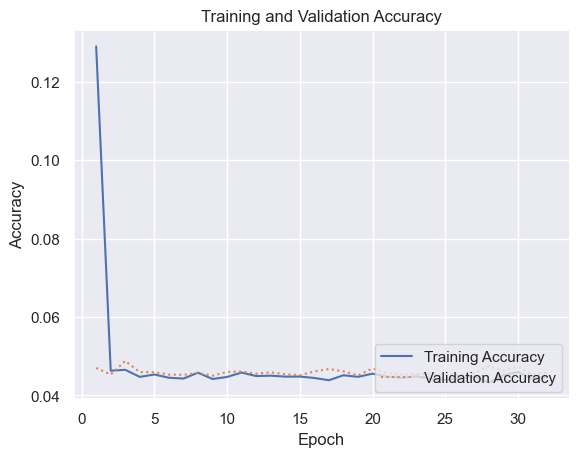

In [276]:
view_accuracy_metrics(hist, 'mae', 'val_mae')

In [277]:
model.save(cwd + '\\my_models\\my_bad_model3.h5')

### Focusing on more abstract feature maps

In [278]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber

loss = Huber(delta=1.0)

model = Sequential()
model.add(Conv2D(24, (3, 3), activation='relu', input_shape=(170, 170, 1)))
model.add(MaxPooling2D(2, 2)) 
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))


In [279]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))


In [280]:
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 168, 168, 24)      240       
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 84, 84, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_219 (Conv2D)         (None, 82, 82, 32)        6944      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 41, 41, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_220 (Conv2D)         (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 19, 19, 64)     

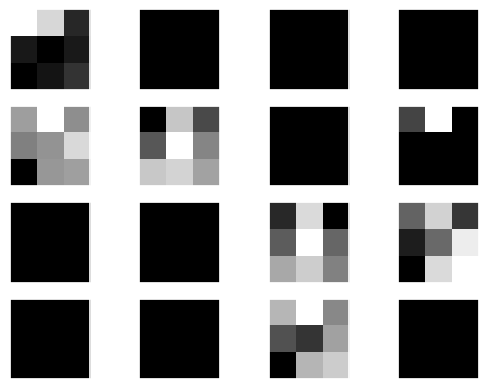

In [281]:
show_feat_map(model, X_test)

In [282]:
model.add(Flatten())
model.add(Dense(170, activation='relu'))
model.add(Dense(4, activation='linear'))
model.compile(optimizer='adam', loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)


Model: "sequential_26"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_218 (Conv2D)                (None, 168, 168, 24)            240         
                                                                                
 max_pooling2d_125 (MaxPooling2D)   (None, 84, 84, 24)              0           
                                                                                
 conv2d_219 (Conv2D)                (None, 82, 82, 32)              6944        
                                                                                
 max_pooling2d_126 (MaxPooling2D)   (None, 41, 41, 32)              0           
                                                                                
 conv2d_220 (Conv2D)                (None, 39, 39, 64)              18496       
                                                                                
 max_

In [283]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=100, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 130ms/step - loss: 0.0067 - accuracy: 0.3768 - val_loss: 0.0017 - val_accuracy: 0.4364
Epoch 2/100
3/3 [==============================] - 0s 52ms/step - loss: 0.0029 - accuracy: 0.3986 - val_loss: 0.0043 - val_accuracy: 0.4545
Epoch 3/100
3/3 [==============================] - 0s 52ms/step - loss: 0.0044 - accuracy: 0.4565 - val_loss: 0.0028 - val_accuracy: 0.4545
Epoch 4/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0026 - accuracy: 0.4565 - val_loss: 0.0018 - val_accuracy: 0.4545
Epoch 5/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0022 - accuracy: 0.4565 - val_loss: 0.0017 - val_accuracy: 0.4364
Epoch 6/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0018 - accuracy: 0.4022 - val_loss: 0.0015 - val_accuracy: 0.4364
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0016 - accuracy: 0.4022 - val_loss: 0.0012 - val_accuracy: 0.4909
Epoch 8/100
3/3 [==

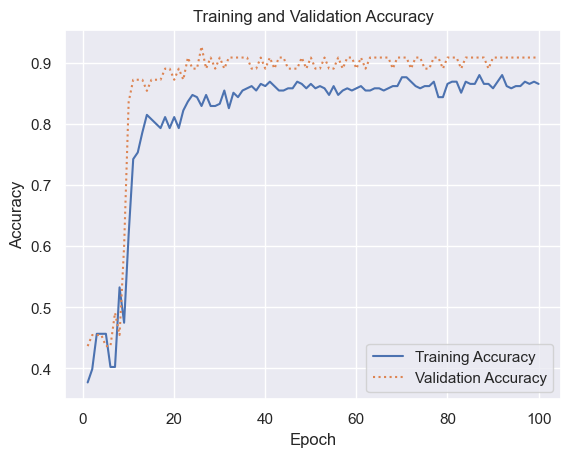

In [284]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [285]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 0s 0s/step


In [286]:
model.save(cwd + '\\my_models\\my_bad_model4.h5')

### Attempting to tune the previous design

In [287]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import Huber

loss = Huber(delta=1.0)

model = Sequential()

#Block1
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1), input_shape=(170, 170, 1)))
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2)) 

#Block2
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))


In [288]:
#Block2
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))

#Block3
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_223 (Conv2D)         (None, 168, 168, 24)      240       
                                                                 
 conv2d_224 (Conv2D)         (None, 166, 166, 24)      5208      
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 83, 83, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_225 (Conv2D)         (None, 81, 81, 32)        6944      
                                                                 
 conv2d_226 (Conv2D)         (None, 79, 79, 32)        9248      
                                                                 
 max_pooling2d_131 (MaxPooli  (None, 39, 39, 32)       0         
 ng2D)                                               

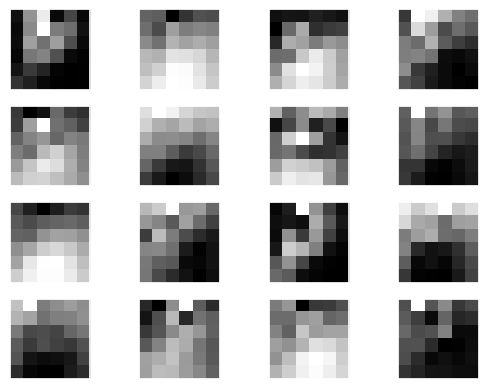

In [290]:
show_feat_map(model, X_test)

In [291]:
model.add(Flatten())
model.add(Dense(170, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(170, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(4, activation='linear'))

model.compile(optimizer='adam', loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)


Model: "sequential_27"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_223 (Conv2D)                (None, 168, 168, 24)            240         
                                                                                
 conv2d_224 (Conv2D)                (None, 166, 166, 24)            5208        
                                                                                
 max_pooling2d_130 (MaxPooling2D)   (None, 83, 83, 24)              0           
                                                                                
 conv2d_225 (Conv2D)                (None, 81, 81, 32)              6944        
                                                                                
 conv2d_226 (Conv2D)                (None, 79, 79, 32)              9248        
                                                                                
 max_

In [292]:
hist = model.fit(X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=100, epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 173ms/step - loss: 0.0098 - accuracy: 0.2283 - val_loss: 0.0068 - val_accuracy: 0.5818
Epoch 2/100
3/3 [==============================] - 0s 102ms/step - loss: 0.0063 - accuracy: 0.4710 - val_loss: 0.0033 - val_accuracy: 0.4545
Epoch 3/100
3/3 [==============================] - 0s 103ms/step - loss: 0.0031 - accuracy: 0.4565 - val_loss: 0.0017 - val_accuracy: 0.4364
Epoch 4/100
3/3 [==============================] - 0s 99ms/step - loss: 0.0020 - accuracy: 0.4022 - val_loss: 0.0019 - val_accuracy: 0.3091
Epoch 5/100
3/3 [==============================] - 0s 102ms/step - loss: 0.0020 - accuracy: 0.4130 - val_loss: 0.0016 - val_accuracy: 0.4545
Epoch 6/100
3/3 [==============================] - 0s 98ms/step - loss: 0.0018 - accuracy: 0.4565 - val_loss: 0.0015 - val_accuracy: 0.4545
Epoch 7/100
3/3 [==============================] - 0s 102ms/step - loss: 0.0017 - accuracy: 0.4565 - val_loss: 0.0014 - val_accuracy: 0.4545
Epoch 8/100
3/3

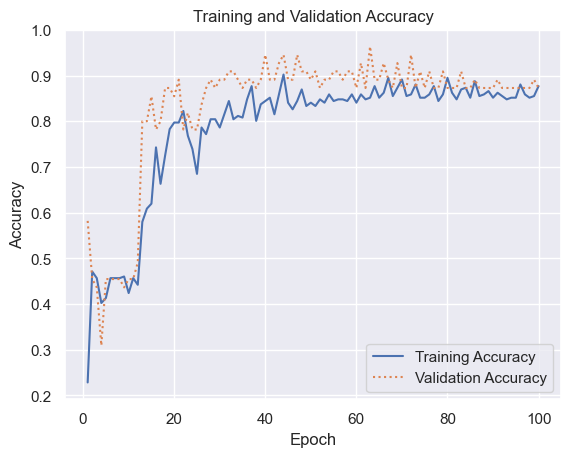

In [293]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [294]:
bounds = model.predict(X_test)
view_image(X_test[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 0s 10ms/step


In [295]:
model.save(cwd + '\\my_models\\my_bad_model6.h5')

### Creating same model but training on uncropped data
This left me with large images, didn't train well, it has decent accuracy relative to the previous models.

In [296]:
model = Sequential()

#Block1
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1), input_shape=(512, 512, 1)))
model.add(Conv2D(24, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2)) 

#Block2
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))

#Block2
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))

#Block3
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(4, activation='linear'))

model.compile(optimizer='adam', loss=loss,
             metrics=['accuracy'])
model.summary(line_length=80)




Model: "sequential_28"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_231 (Conv2D)                (None, 510, 510, 24)            240         
                                                                                
 conv2d_232 (Conv2D)                (None, 508, 508, 24)            5208        
                                                                                
 max_pooling2d_134 (MaxPooling2D)   (None, 254, 254, 24)            0           
                                                                                
 conv2d_233 (Conv2D)                (None, 252, 252, 32)            6944        
                                                                                
 conv2d_234 (Conv2D)                (None, 250, 250, 32)            9248        
                                                                                
 max_

In [299]:
hist = model.fit(X_train_uncropped, y_train_uncropped,
                validation_data=(X_val_uncropped, y_val_uncropped),
                batch_size=8, epochs=100)

Epoch 1/100
35/35 [==============================] - 5s 111ms/step - loss: 2.9935 - accuracy: 0.3116 - val_loss: 0.0161 - val_accuracy: 0.6182
Epoch 2/100
35/35 [==============================] - 3s 87ms/step - loss: 0.0133 - accuracy: 0.2826 - val_loss: 0.0068 - val_accuracy: 0.4545
Epoch 3/100
35/35 [==============================] - 3s 88ms/step - loss: 0.0061 - accuracy: 0.3804 - val_loss: 0.0033 - val_accuracy: 0.5818
Epoch 4/100
35/35 [==============================] - 3s 88ms/step - loss: 0.0035 - accuracy: 0.4239 - val_loss: 0.0024 - val_accuracy: 0.6182
Epoch 5/100
35/35 [==============================] - 3s 88ms/step - loss: 0.0016 - accuracy: 0.4928 - val_loss: 0.0014 - val_accuracy: 0.4909
Epoch 6/100
35/35 [==============================] - 3s 87ms/step - loss: 0.0011 - accuracy: 0.5000 - val_loss: 0.0011 - val_accuracy: 0.8000
Epoch 7/100
35/35 [==============================] - 3s 88ms/step - loss: 6.5908e-04 - accuracy: 0.6051 - val_loss: 4.7558e-04 - val_accuracy: 0.80

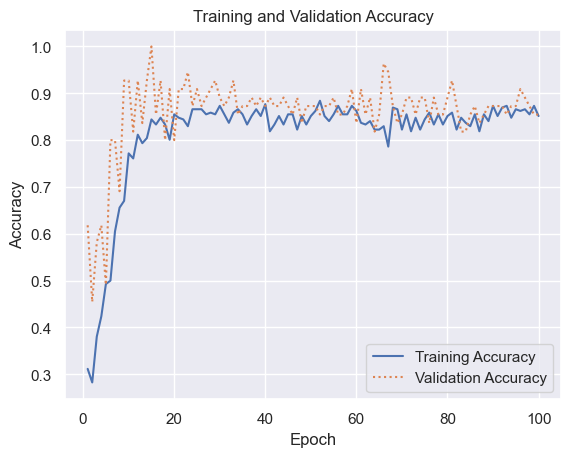

In [300]:
view_accuracy_metrics(hist, 'accuracy', 'val_accuracy')

In [301]:
bounds = model.predict(X_test_uncropped)
view_image(X_test_uncropped[1], int(bounds[1][0]*512),
            int(bounds[1][1]*512), int(bounds[1][2]*512), int(bounds[1][3]*512))

2/2 [==============================] - 1s 85ms/step


In [302]:
model.save(cwd + '\\my_models\\no_crop_model7.h5')

Clearing memory that python and tensoflow have loaded onto ram and vram

In [303]:
# Clearing gpu and python memory
import gc

tf.keras.backend.clear_session()
gc.collect()

41015